<a href="https://colab.research.google.com/github/TheMrGhostman/NeuroEvolution_for_simple_games/blob/master/NeuroEvolution_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import random
from copy import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import gym

# Definition of classes

In [0]:
class Net(nn.Module):
    """
    Net class represents brain of every agent. 
    Because it is neural network there is some initialization parameters like input dimension (state space), output dimension (action space) and activation function.
    We are suppose that architecture is fixed! => constant number of genes for all agents.
    """
    def __init__(self, in_,  out_, activation=nn.Tanh()):
        """
        : param in_:            Dimension of input (int)
        : param out_:           Dimension of output (int)
        : param acitvation:     Type of activation function used in NN except output layer (torch.nn.module)
        """
        super(Net, self).__init__()
        self.in_ = in_
        self.out_ = out_
        self.module_list = [in_, 160,160,160, out_]
        self.model = self.setup_model(activation)
        self.n_weights = self.sum_parameters(self.model)

    @staticmethod
    def sum_parameters(model):
        """
        Helper function for suming all parameters in NN (number of genes).
        """
        def prod(array):
            array = np.array(array)
            return array.prod()
        n_params = 0
        for param in model.parameters():
            n_params += prod(param.shape)
        return n_params
    
    def setup_model(self, activation):
        """
        Helper functin for creating model with given parameters. 
        """
        od = {}
        for i in range(len(self.module_list)-1):
            od[f"layer_{i}"] = nn.Linear(self.module_list[i], self.module_list[i+1], bias=False)
            if i!=len(self.module_list)-2:
                od[f"activation_{i}"] = activation
        model = nn.Sequential(OrderedDict(od))
        for params in model.parameters():
            params.requires_grad=False
        return model

    def forward(self, x):
        """
        Obligatory function defining forward pass through network.
        """
        return self.model(x)

In [0]:
class Agent(object):
    """
    Class agent connects brain (neural network) with enviroment. 
    Includes other functions required by evolutionary algorithm like get_genes, set_genes. 
    """
    def __init__(self, state_space, action_space):
        """
        Parmas for brain 
        : param state_space:       Dimensions of state space (int)
        : param action_space:      Dimensions of action space (int)
        """
        self.state_space = state_space
        self.action_space = action_space
        self.brain = Net(in_=state_space, out_=action_space)
        self.n_genes = self.brain.n_weights 
        # agents memory
        self.reached_score = 0 # setting agent reached score to 0
        self.new_state = None  
        self.done = False


    def act(self, state):
        """
        Function for online training or testing
        """
        predicted_action = torch.sigmoid(self.brain(state))
        return predicted_action
    
    def act_from_memory(self, argmax=False):
        """
        : param argmax:         Apply argmax on output of nn or not. When game 
                                controls are discrete is argmax needed (classification). 
                                In case games with continuous argmax can not be used 
                                (regression). 
        """
        if argmax:
            return torch.argmax(self.brain(torch.tensor(self.new_state).float()))
        else:
            return torch.sigmoid(self.brain(torch.tensor(self.new_state).float()))

    def update_agent(self, NsRD_):
        """
        Function which updates memory of agent.
        : param NsRD_ :         (New state, Reward, Done, info)
        """
        self.new_state = NsRD_[0]
        self.reached_score += NsRD_[1]
        self.done = NsRD_[2]

    def get_genes(self):
        """
        Returns agent's genes in form of 1D vector (list) instead of multiple 2D tensors.
        """
        def prod(array):
            array = np.array(array)
            return array.prod()
        gene = []
        config_size = []
        config_idx = []
        for param in self.brain.parameters():
            pr = int(self.prod(param.shape))
            config_size.append(param.shape)
            config_idx.append(pr)
            gene.append(param.view(pr))
        config_idx = np.cumsum(config_idx)
        config = [(size, idx) for size, idx in zip(config_size, config_idx)]
        gene = torch.cat(gene)
        return gene, config

    def set_genes(self, gene, config):
        """
        Convering 1D gene vector to form used in nn layers and seting new weights.
        """
        config.insert(0, (0, 0))
        for i, param in enumerate(self.brain.parameters()):
            param = gene[config[i][1]:config[i+1][1]].view(config[i+1][0])
        return self


# Evolutionary Algorithm 

![alt text](https://miro.medium.com/max/1400/1*f7YNgme2E0vv--NyW39B2A.png)

## Fitnes claculation
- standardized game score (in generation)
\begin{equation}
    S_r = \frac{ S_{measured} - \min( S_{measured} )}{\max( S_{measured} ) - \min( S_{measured} )} 
\end{equation}

## Selection & Pairing
- Rullete wheel selection
- select $N/2$ agents
- each agent has change to be selected with probability 
\begin{equation}
    p_i = \frac{S_{real}^i}{\sum_{i=0}^N S_{real}^i}
\end{equation}
- Agents are randomly paried

## Mating (Crossover)
- sigle point method 
- genes of agent A and B are splited to two slices by random index
- combine A's first slice with B's second slice and vice versa
![alt text](https://miro.medium.com/max/1340/1*K1hfu6HgzeLpZL3BcBykWg.png)

## Mutation
 - Output agents from mating are copied and mutated
 - genes are continuous =>  Gaussian method
 \begin{equation}
 \vec{W} = \vec{W} + \sigma \cdot \Delta \odot B
 \end{equation}
 - $\Delta_{i,j} \sim \mathcal{N}(0, 1)$ and $B_{i,j} \sim Bernoulli(p)$ 

## New generation
- 1st half from Mating ($N/2$) and 2nd half from Mating + Mutation ($N/2$)

In [0]:
class Population(object):
    """
    Class Population stores all agents and includes evolutionary algorithm. 
    """
    def __init__(self, n_agents, state_space, action_space):
        """
        m_agents should be divisible with 2 without remainder 
        """
        self.n_agents = n_agents
        self.population = self.create_population(n_agents, state_space, action_space)
        self.scores_per_generation = {"min":[], "max":[], "mean":[], "std":[]}

    @staticmethod
    def create_population(n_agents, state_space, action_space):
        """
        Creating list of agents. 
        """
        pop = []
        for i in range(n_agents):
            pop.append(Agent(state_space=state_space, action_space=action_space))
        return pop

    @staticmethod
    def mating(A, B):
        """
        Mating (crossover) of two agents. 
        Single point method. 
        """
        A_gene, A_config = A.get_genes()
        B_gene, B_config = A.get_genes()
        idx = np.random.randint(low=0, high=A_gene.shape[0])
        # splitting genes to two slices and combine A's first slice with B's second slice and vice versa
        A_gene_new = torch.cat((A_gene[:idx], B_gene[idx:]))
        B_gene_new = torch.cat((B_gene[:idx], A_gene[idx:]))
        # assign new A gene to Agent A and new B gene to Agent B
        A.set_genes(A_gene_new, A_config)
        B.set_genes(B_gene_new, B_config)
        return A, B
    
    @staticmethod
    def mutation(A, probability, sigma=1):
        """
        Function for mutation where every gene can be changed by sigma*N(0,1) with given probability. 
        """
        A_gene, A_config = A.get_genes()
        # prepeare gaussian generation -> x~N(0, 1) ...... sigma*x + mu ~ N(mu, sigma)
        mut = torch.randn_like(A_gene)
        # select weights which will change
        b = torch.distributions.Bernoulli(probs=probability*torch.ones_like(A_gene)).sample()
        # final mutation
        A_gene = A_gene + sigma*mut*b
        A.set_genes(A_gene, A_config)
        return A

    def optimizatin_loop(self, envs, n_generations, repeats=3, use_argmax=True, probability=0.1, sigma=1, replace=False):
        """
        Optimalization (evolutionary) loop. 

        """
        for generation in tqdm(range(n_generations)):
            scores = []
            # reset
            for i in range(repeats):
                for agent, env in zip(self.population, envs):
                    # reset enviroment
                    agent.new_state = env.reset()
                    # reset reached score
                    agent.reached_score = 0
                    agent.done=False
                
                # evaluation fitness function
                for s in range(500):
                    for agent, env in zip(self.population, envs):
                        if agent.done:
                            continue
                        else:
                            # argmax
                            act = np.array(agent.act_from_memory(argmax=use_argmax))
                            agent.update_agent(env.step(act))
                # appending score
                scores.append(np.array([agent.reached_score for agent in self.population]))

            # complete evaluation in generation
            scores = np.vstack(scores).mean(axis=0) # mean score of through repeats
            # loging results
            self.scores_per_generation["min"].append(np.min(scores))
            self.scores_per_generation["max"].append(np.max(scores))
            self.scores_per_generation["mean"].append(np.mean(scores))
            self.scores_per_generation["std"].append(np.std(scores))
                
            # i want to return last evaluated generation
            if generation==n_generations-1:
                break
            else:
                # sort population according to fitness (score) and sort score
                # self.population = [pop for (_, pop) in sorted(zip(np.array(scores), self.population), reverse=True)]  
                #       => somehow it does not work becouse of TypeError: '<' not supported between instances of 'Agent' and 'Agent'
                tmp = [idx for (_, idx) in sorted(zip(np.array(scores), np.arange(self.n_agents)), reverse=True)]
                self.population = [self.population[i] for i in tmp]
                scores = sorted(scores, reverse=True)
                # save best agent
                self.best_agent = self.population[0]

                # scale scores MinMaxScaler
                scaled_scores = (scores - np.min(scores))/(np.max(scores)-np.min(scores))
                # scaled scores to probability
                scaled_scores = scaled_scores/np.sum(scaled_scores)

                # Roulette wheel selection
                chosen_pairs = np.random.choice(self.population, size= int(self.n_agents/2)//2*2, replace=replace, p=scaled_scores).tolist() # => fix for both negatives and positives
                # I want half of current generation to be chosen and divisible with 2 without remainder
                # agents are already shuffled so i can pair them now -> random pairing
                new_pop = []
                for i in range(0,len(chosen_pairs), 2):
                    A, B = self.mating(chosen_pairs[i], chosen_pairs[i+1])
                    new_pop.append(A)
                    new_pop.append(B)
                # new_pop has now half of original count of agents
                self.population = copy(new_pop)
                for agent in new_pop:
                    self.population.append(self.mutation(copy(agent), probability, sigma))
                assert len(self.population)==self.n_agents
                # now we have new generation
        return self



    

    

# test run

In [0]:
# hyperparameters
POPULATION = 200
GENERATIONS = 100
REPEATS=3

# Cartpole enviroment

## Points
- agent gets 1 point for every frame when Pole Angle is not more than 12 degrees.
 - $Pole Angle> 12$ => game over for agent

## state space
>```
Observation:
    Type: Box(4)
    Num   Observation               Min             Max
    0     Cart Position             -4.8            4.8
    1     Cart Velocity             -Inf            Inf
    2     Pole Angle                -24 deg         24 deg
    3     Pole Velocity At Tip      -Inf            Inf
```
## action space
>```
Actions:
    Type: Discrete(2)
    Num   Action
    0     Push cart to the left
    1     Push cart to the right
```

![alt text](https://miro.medium.com/max/1200/1*LnQ5sRu-tJmlvRWmDsdSvw.gif)

In [0]:

# setting enviroment for all agents
multi_enviroment = [gym.make("CartPole-v1") for i in range(POPULATION)]

STATE_SPACE = multi_enviroment[0].observation_space.shape[0]
ACTION_SPACE = multi_enviroment[0].action_space.n

In [0]:
# creating population
pop = Population(POPULATION, STATE_SPACE, ACTION_SPACE)

In [0]:
# calling optimization loop
pop.optimizatin_loop(
    envs=multi_enviroment, 
    n_generations=GENERATIONS,  
    repeats=REPEATS, 
    use_argmax=True, 
    probability=0.2, 
    sigma=0.5,
    replace=False)



# stoped after 38th generation. 

After 38th generation was game stopped because the game winning rules was meet.


![alt text](https://thumbs.gfycat.com/GreedyJampackedBlackfish-size_restricted.gif)


# Plotting measured statistics 

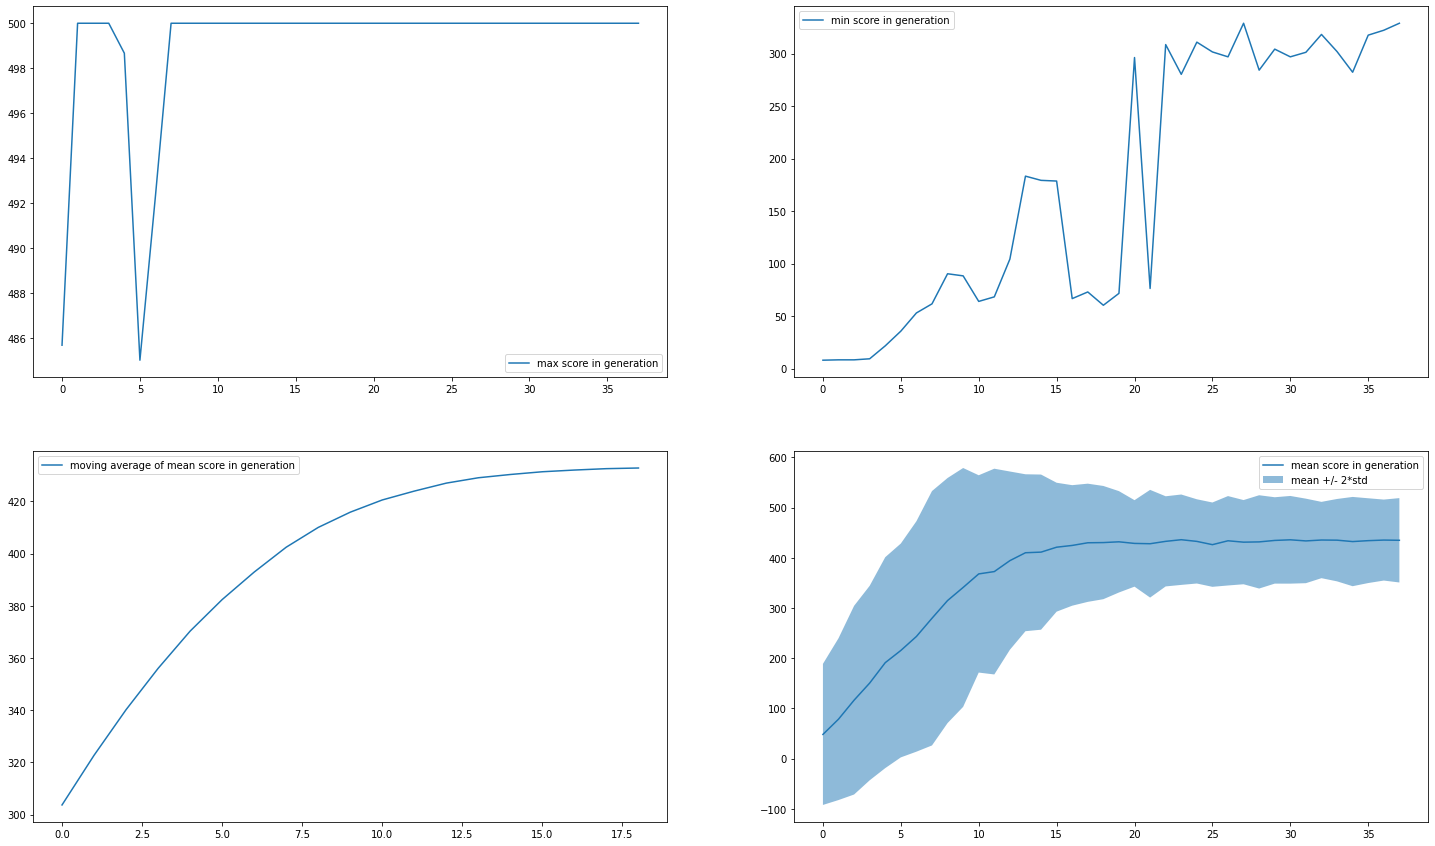

In [0]:
fig, axe = plt.subplots(2,2,figsize=(25,15))
axe[0,0].plot(pop.scores_per_generation["max"], label="max score in generation")
axe[0,0].legend()

axe[0,1].plot(pop.scores_per_generation["min"], label="min score in generation")
axe[0,1].legend()

axe[1,0].plot(np.convolve(pop.scores_per_generation["mean"], np.ones((20))/20, mode='valid'), label="moving average of mean score in generation")
axe[1,0].legend()

axe[1,1].plot(pop.scores_per_generation["mean"], label="mean score in generation")
axe[1,1].fill_between(np.arange(len(pop.scores_per_generation["mean"])), 
                      np.array(pop.scores_per_generation["mean"]) + 2 * np.array(pop.scores_per_generation["std"]), 
                      np.array(pop.scores_per_generation["mean"]) - 2 * np.array(pop.scores_per_generation["std"]), 
                      alpha = 0.5, label="mean +/- 2*std")
axe[1,1].legend()